In this notebook, we will study how homeostasis (cooperation) may be an essential ingredient to this algorithm working on a winner-take-all basis (competition). This extension has been published as Perrinet, Neural Computation (2010) (see  https://laurentperrinet.github.io/publication/perrinet-10-shl ). In particular, we will show how one can build the non-linear functions based on the activity of each filter and which implement homeostasis.

See also the other posts on [unsupervised learning](https://laurentperrinet.github.io/sciblog/categories/learning.html),

This is joint work with [Victor Boutin](https://laurentperrinet.github.io/authors/victor-boutin).

<!-- TEASER_END -->

Conclusion: using Pcum functions seems to work, but one needs to learn the non-linear functions in a smooth manner. This will be done in a next post.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#%config InlineBackend.figure_format='svg'

import numpy as np
np.set_printoptions(formatter = dict( float = lambda x: "%.3g" % x ), precision=3, suppress=True, threshold=np.inf)

import time

## starting with a short learning without homeostasis

In [2]:
DEBUG = True
DEBUG = False
if not DEBUG:
    matname = '2017-05-31_Testing_COMPs'
    DEBUG_DOWNSCALE = 1
else:
    matname = '2017-05-31_Testing_COMPs-DEBUG'
    DEBUG_DOWNSCALE = 10

seed = 42
nb_quant = 512
C = 5.
do_sym = False

from shl_scripts.shl_experiments import SHL
shl = SHL(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, seed=seed, 
           eta=0.05, verbose=2, record_each=50, n_iter=1000, eta_homeo=0., alpha_homeo=1., 
          do_sym=do_sym, nb_quant=nb_quant, C=C)
data = shl.get_data(matname=matname)

loading the data called : data_cache/2017-05-31_Testing_COMPs_data


In [3]:
test_size = data.shape[0]//2
data_training = data[:test_size, :]
data_test = data[test_size:,:]   
#DEBUG
test_size = data.shape[0]//20
data_training = data[:(data.shape[0]-test_size),:].copy()
data_test = data[:test_size, :].copy()

We start off by using a short learning with no homeostasis such that we end up with a unbalanced dictionary:

In [4]:
dico_partial_learning = shl.learn_dico(data=data_training, matname=matname)

loading the dico called : data_cache/2017-05-31_Testing_COMPs_dico.pkl


In [5]:
dico_partial_learning.P_cum

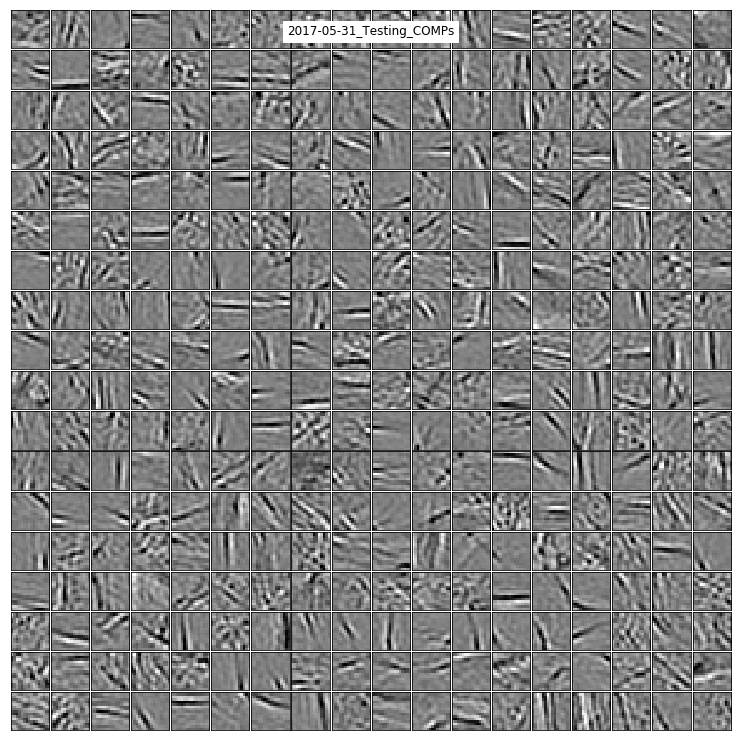

In [6]:
fig, ax = shl.show_dico(dico_partial_learning, data=data, title=matname)
fig.show()

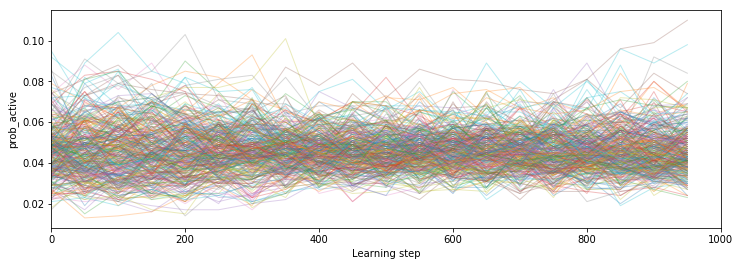

In [7]:
fig, ax = shl.time_plot(dico_partial_learning, variable='prob_active');
fig.show()

## classical Matching Pursuit

In [8]:
#n_samples, n_pixels = data_test.shape
#n_dictionary, n_pixels = dico_partial_learning.dictionary.shape
norm_each_filter = np.sqrt(np.sum(dico_partial_learning.dictionary**2, axis=1))
print('L2 norm of each filter=', norm_each_filter)
dico_partial_learning.dictionary /= norm_each_filter[:,np.newaxis]

sparse_code_mp = shl.code(data_test, dico_partial_learning, matname=matname)


L2 norm of each filter= [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
loading the code called : data_cache/2017-05-31_Testing_COMPs_coding.npy


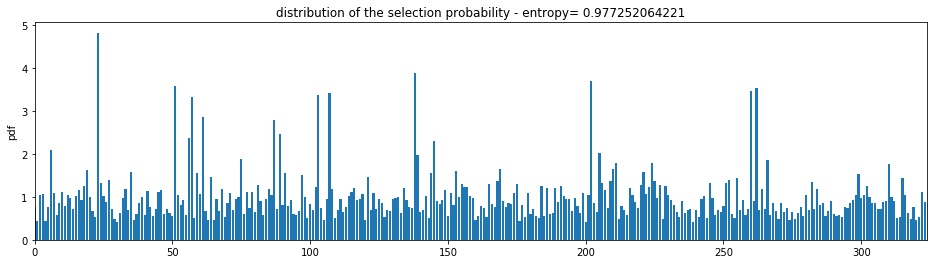

In [9]:
def plot_proba_histogram(coding):
    n_dictionary=coding.shape[1]

    p = np.count_nonzero(coding, axis=0)/coding.shape[1]
    p /= p.sum()
    rel_ent = np.sum( -p * np.log(p)) / np.log(n_dictionary)
    #print('Entropy / Entropy_max=', rel_ent )

    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(111)
    ax.bar(np.arange(n_dictionary), p*n_dictionary)
    ax.set_title('distribution of the selection probability - entropy= ' + str(rel_ent)  )
    ax.set_ylabel('pdf')
    ax.axis('tight')
    ax.set_xlim(0, n_dictionary)
    return fig, ax

fig, ax = plot_proba_histogram(sparse_code_mp)

In [10]:
p = np.count_nonzero(sparse_code_mp, axis=0)
print('relative proba of being selected', p/p.mean())
print('most selected filter : {}'.format(np.argmax(p)))
print('less selected filter : {}'.format(np.argmin(p)))

relative proba of being selected [0.772 0.439 1.04 1.06 0.444 0.761 2.09 1.09 0.587 0.867 1.1 0.793 1.04
 0.973 0.714 1.02 1.17 0.92 1.25 1.63 0.989 0.666 0.523 4.82 1.33 1.03
 0.883 1.4 0.708 0.481 0.412 0.619 0.973 1.18 0.693 1.57 0.455 0.597 0.862
 1 0.576 1.14 0.772 0.56 0.708 1.12 1.16 0.597 0.724 0.613 0.555 3.58 1.05
 0.798 0.93 0.576 2.36 3.31 0.497 1.56 1.07 2.86 0.671 0.455 1.45 0.455
 0.952 0.661 1.18 0.529 0.862 1.09 0.693 0.941 1 1.88 0.603 1.11 0.735 1.12
 0.656 1.28 0.909 0.566 0.952 1.19 1.05 2.78 0.719 2.47 0.809 1.55 0.782
 0.93 0.592 0.582 0.671 1.51 1 0.513 0.825 0.687 1.23 3.37 0.735 0.449
 0.952 3.4 1.19 0.518 0.687 0.957 0.645 0.761 1.02 1.12 1.21 0.915 0.946
 1.07 0.449 1.46 0.693 1.08 0.719 0.957 0.856 0.539 0.698 0.661 0.941 0.967
 0.994 0.624 1.19 0.936 0.756 0.74 3.88 1.96 0.64 0.693 1.02 0.497 1.55
 2.29 0.893 0.83 0.936 1.15 0.56 1.08 0.804 1.61 1 1.3 1.23 1.22 1.02 0.983
 0.455 0.55 0.788 0.74 0.523 1.3 0.83 0.767 1.36 1.65 0.893 0.767 0.867
 0.841 1.09 1

## COMP : learning modulations

defining a rescaling function for coefficients to avoid overflows:

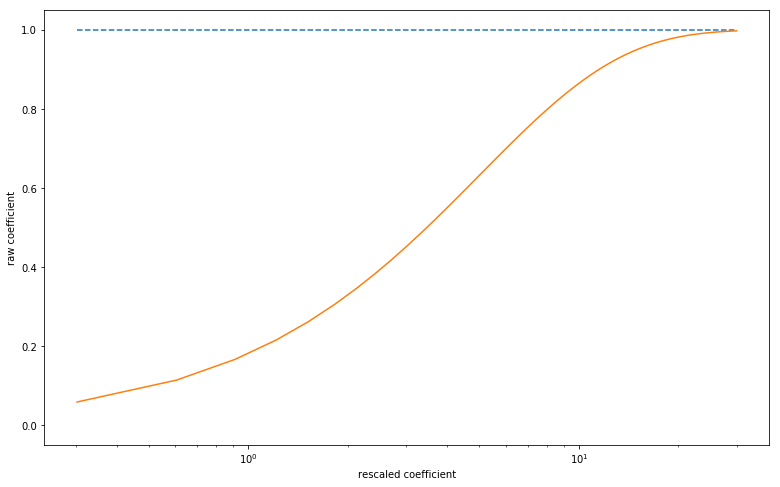

In [11]:
def rescaling(code, C=5., do_sym=True):
    if do_sym:
        return 1.-np.exp(-np.abs(code)/C)
    else:
        return (1.-np.exp(-code/C))*(code>0)
    
fig=plt.figure(figsize=(13, 8))
ax = plt.subplot(111)
x=np.linspace(0, 30, 100)                   
ax.plot(x, np.ones_like(x), '--')
ax.plot(x, rescaling(x, C=C, do_sym=do_sym))
ax.set_ylabel('raw coefficient')
ax.set_xlabel('rescaled coefficient')
ax.set_xscale('log');

In [12]:
def get_P_cum(code, nb_quant=100):    
    n_samples, nb_filter = code.shape
    code_bins = np.linspace(0., 1, nb_quant, endpoint=True)
    P_cum = np.zeros((nb_filter, nb_quant))
    for i in range(nb_filter):
        p, bins = np.histogram(rescaling(code[:, i], C=C, do_sym=do_sym), bins=code_bins, density=True)
        p /= p.sum()
        P_cum[i, :] = np.hstack((0, np.cumsum(p)))
    return P_cum

P_cum_mp = get_P_cum(sparse_code_mp, nb_quant=nb_quant)

(0.85, 1.01)

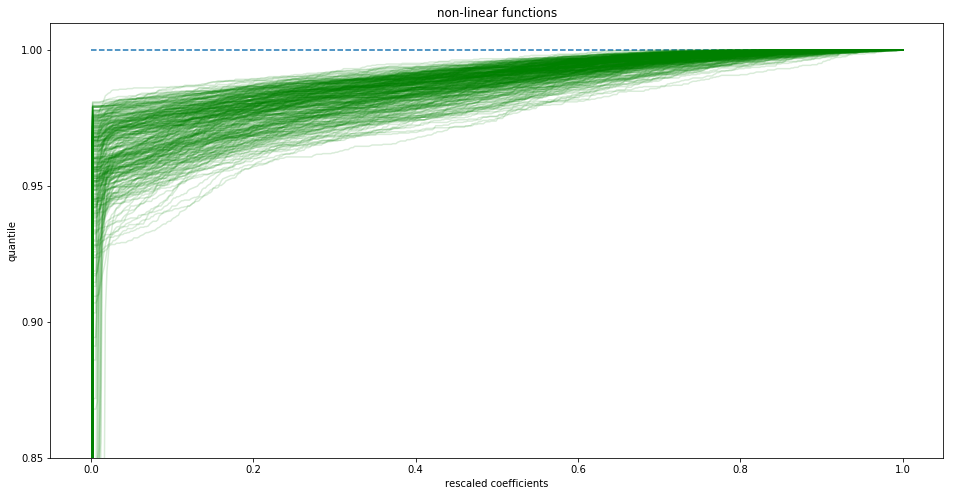

In [13]:
from shl_scripts.shl_tools import plot_P_cum
fig, ax = plot_P_cum(P_cum_mp, verbose=False, alpha=.15);
ax.set_ylim(0.85, 1.01)
#ax.set_xmargin(0.);

## COMP : using modulations


Computing a quantile using ```np.interp```:


In [14]:
code_bins = np.linspace(0., 1, nb_quant+1, endpoint=True)
def quantile(code_bins, Pcum, c):
    q_i = np.zeros_like(c)
    for i in range(Pcum.shape[0]):
        q_i[i] = np.interp(c[i], code_bins[:-1], Pcum[i, :])
    return q_i

corr = (data_test @ dico_partial_learning.dictionary.T)[0, :]
P_cum = P_cum_mp.copy()
print('correlation=', corr)
print('rescaled correlation=', rescaling(corr, C=C, do_sym=do_sym))
print('quantile=', quantile(code_bins, P_cum, rescaling(corr, C=C, do_sym=do_sym)))

correlation= [-0.578 2.52 0.51 -0.0995 -0.48 -0.397 -1.18 1.01 0.368 -0.0685 -0.638 0.73
 0.662 -0.177 -0.735 -0.16 -0.313 -0.408 0.194 -0.0507 0.0542 -0.224 0.245
 0.213 0.606 0.375 0.375 0.24 0.31 0.798 0.0375 -0.36 -1.16 0.327 -0.447
 -0.221 -0.174 -0.503 0.403 -0.02 -0.318 -0.000521 -1.63 0.932 -1.4 -0.0734
 0.511 -1.93 -0.273 0.0229 -0.257 -0.173 0.41 -0.287 -0.00687 -0.0753 0.386
 -0.586 -0.351 -0.225 0.466 1.95 -0.144 -0.768 -0.159 0.761 -0.0439 -1.94
 0.00655 0.322 0.0772 0.0734 -0.395 -0.445 -0.114 0.00327 0.467 -0.417 0.49
 0.62 -0.183 0.696 0.302 -0.354 0.146 -0.225 -0.873 -0.321 0.398 0.514
 -0.705 0.174 -0.143 0.417 -1.59 0.0991 -0.407 -0.294 0.612 0.172 -0.761
 0.389 0.235 0.354 1.12 -0.945 -0.643 0.656 0.22 -0.478 -0.929 -0.876 2.81
 0.309 -0.0675 1.09 -0.0483 0.247 0.265 -0.199 0.416 0.213 -0.102 0.5 0.72
 0.876 -0.0915 -0.947 0.465 0.544 -0.488 0.323 0.09 1.09 0.294 0.597 0.053
 0.583 0.302 -0.328 -0.711 -0.283 0.737 0.35 -0.231 0.306 0.0878 -0.0276
 -1.05 -0.371 -0.47

Such that we can redefine Matching Pursuit by including this non-linear function:

In [15]:
l0_sparseness = shl.l0_sparseness

def comp(data, dico, code_bins, P_cum, l0_sparseness=l0_sparseness, verbose=0):
    if verbose!=0:
        t0 = time.time()
    n_samples, n_dictionary = data.shape[0], dico.shape[0]
    sparse_code = np.zeros((n_samples, n_dictionary))
    corr = (data @ dico.T)
    Xcorr = (dico @ dico.T)
    
    for i_sample in range(n_samples):
        c = corr[i_sample, :].copy()
        if verbose!=0: ind_list=list()
        for i_l0 in range(int(l0_sparseness)):
            
            if P_cum is None:
                q_i = rescaling(c, C=C, do_sym=do_sym)
            else:
                q_i = quantile(code_bins, P_cum, rescaling(c, C=C, do_sym=do_sym))
                
            ind  = np.argmax(q_i)
            if verbose!=0:
                ind_list.append(ind)

            c_ind = c[ind] / Xcorr[ind, ind]
            sparse_code[i_sample, ind] += c_ind
            c -= c_ind * Xcorr[ind, :]

        if verbose!=0:
            if i_sample in range(2):
                q_i = quantile(code_bins, P_cum, rescaling(c, C=C, do_sym=do_sym))
                print(ind_list, [q_i[i] for i in ind_list], np.median(q_i), q_i.max(), [c[i] for i in ind_list], c.min(), c.max())
    if verbose!=0:
        duration = time.time()-t0
        print('coding duration : {0}s'.format(duration))

    return sparse_code

sparse_code = comp(data_test, dico_partial_learning.dictionary, code_bins, P_cum, verbose=1)

[1, 133, 320, 221, 276, 194, 112, 221, 61, 317, 120, 180, 313, 1, 30] [0.97973632812500011, 0.975341796875, 0.0, 0.0, 0.97803881875671017, 0.0, 0.0, 0.0, 0.96484375, 0.0, 0.982177734375, 0.97202625953524369, 0.98150739846300095, 0.97973632812500011, 0.0] 0.0 0.982177734375 [0.058885183324112515, 0.20871222858305538, -0.093887979122806831, -0.074365497468498992, 0.069296363126686925, -0.14640867668556121, -0.1515863408494843, -0.074365497468498992, 0.16783330681509309, -0.044130427335518807, 0.30755391951210032, 0.063087338988091324, 0.17011884150536954, 0.058885183324112515, 0.0] -0.896107961193 1.07584577964
[313, 36, 46, 281, 288, 276, 265, 78, 0, 244, 50, 283, 70, 63, 314] [0.0, 0.98095703125, 0.0, 0.98388671875, 0.0, 0.0, 0.96721837144303968, 0.99072265625, 0.96745312439172237, 0.0, 0.97932618006081851, 0.0, 0.96728515625000011, 0.979736328125, 0.0] 0.0 0.9912109375 [-2.568570658447952, 0.61935695626241805, -0.083715077906073534, 1.3890114841172858, -0.25149834124726606, -0.5700038

In [16]:
sparse_code.shape

(4096, 324)

In [17]:
np.mean(np.count_nonzero(sparse_code, axis=0)/sparse_code.shape[1])

0.50696349641822891

In [18]:
np.count_nonzero(sparse_code, axis=0)

array([ 254, 1255,   40,   48,  937,  159,   38,   44,  480,   29,   48,
         27,   56,   35,   74,   18,   23,  145,   83,   30,   79,  120,
        230,   45,   64,   89,   67,   48,  112,  958, 1045,   29,   84,
         18,   51,  208,  271, 1581,   34,   30,   62,   94,  160,   69,
         26,   20,   50,   83,   68,   80,   89,   88,   54,   43,   83,
         96,   59,  173, 1393,   37,   34,   86,   38,  364,   32,  473,
         87,  127,   43,  777,  221,  146,   59,  147,   51,   27,   54,
         21,  297,   72,   68,   45,   19,   89,   13,   24,  208,   35,
         25,   32,   20,   40,   84,   15,   84,   82,  111,  245,   14,
        220,  143,   23,   25,   17,   86,  587,  179,  155,   26,  371,
        143,   63,   47,   29,   43,  129,   21,   66,   48,   23,  903,
         35,   33,   23,   75,   43,   38,  397,  105,   88,   68,   23,
         35,  195,   91,   84,   14,   66,   31,   48,   62,   42,  171,
        491,   23,   58,   65,   42,   26,   51,  4

In [19]:
def plot_scatter_MpVsComp(sparse_vector, my_sparse_code):
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(111)
    a_min = np.min((sparse_vector.min(), my_sparse_code.min()))
    a_max = np.max((sparse_vector.max(), my_sparse_code.max()))
    ax.plot(np.array([a_min, a_max]), np.array([a_min, a_max]), 'k--', lw=2)
    
    ax.scatter(sparse_vector.ravel(), my_sparse_code.ravel(), alpha=0.01)
    ax.set_title('MP')
    ax.set_ylabel('COMP')
    #ax.set_xlim(0)
    #ax.set_ylim(0)
    ax.axis('equal')
    return fig, ax

#fig, ax = plot_scatter_MpVsComp(sparse_code_mp, sparse_code)
#fig.show()

## testing that COMP with flat Pcum  is equivalent to MP

In [20]:
n_samples, nb_filter = sparse_code.shape

P_cum = np.linspace(0, 1, nb_quant, endpoint=True)[np.newaxis, :] * np.ones((nb_filter, 1))

sparse_code_comp = comp(data_test, dico_partial_learning.dictionary, code_bins, P_cum, verbose=1)

[112, 1, 176, 259, 194, 61, 320, 257, 199, 219, 115, 120, 180, 12, 81] [0.0, 0.0, 0.0, 0.0, 0.0, 0.013864142875207208, 0.028772536419743071, 0.016233212505017167, 0.0, 0.024265759252589399, 0.10207030152319692, 0.034597904055880355, 0.0, 0.018343420091593308, 0.0] 0.000412864457953 0.141560943202 [-0.44404114150688967, -0.26877134490129767, -0.18201957102880398, -0.12664604750941777, -0.030136470340884552, 0.069668445082797154, 0.14568360795725216, 0.081670932247593975, -0.23606863784845655, 0.12258226214410899, 0.53720753857826176, 0.17570295703817568, -0.033546386202322795, 0.092386254783856453, 0.0] -0.981150296523 0.761587804166
[234, 193, 46, 265, 245, 313, 44, 290, 136, 212, 260, 193, 27, 36, 82] [0.0, 0.0, 0.22563269740595826, 0.015581609675975019, 0.14039962809637588, 0.0, 0.0, 0.11338662816679515, 0.17227117585711077, 0.0, 0.15557370905708512, 0.0, 0.0, 0.070234302641278737, 0.0] 0.0 0.424559659253 [-1.4159508240284979, -0.41402145954707881, 1.2757001664220735, 0.0783668241428

In [21]:
print('Relative difference = ', np.sum((sparse_code_mp - sparse_code_comp)**2)/np.sum((sparse_code_mp)**2))

Relative difference =  0.0


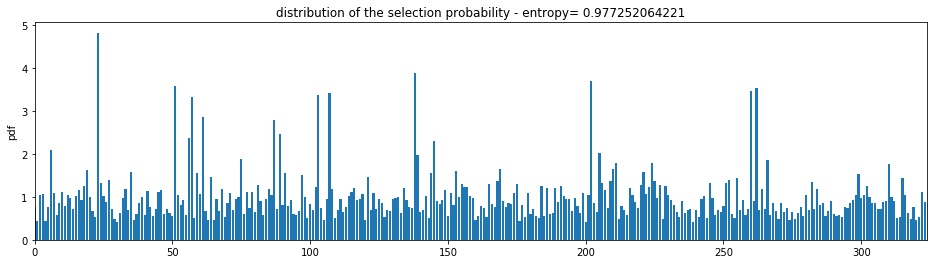

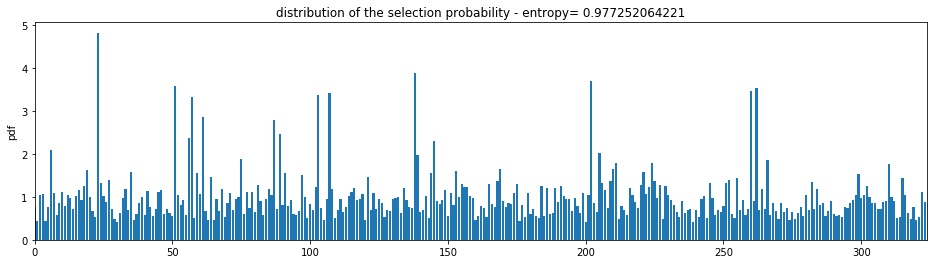

In [22]:
fig, ax = plot_proba_histogram(sparse_code_mp)
fig.show()
fig, ax = plot_proba_histogram(sparse_code_comp)

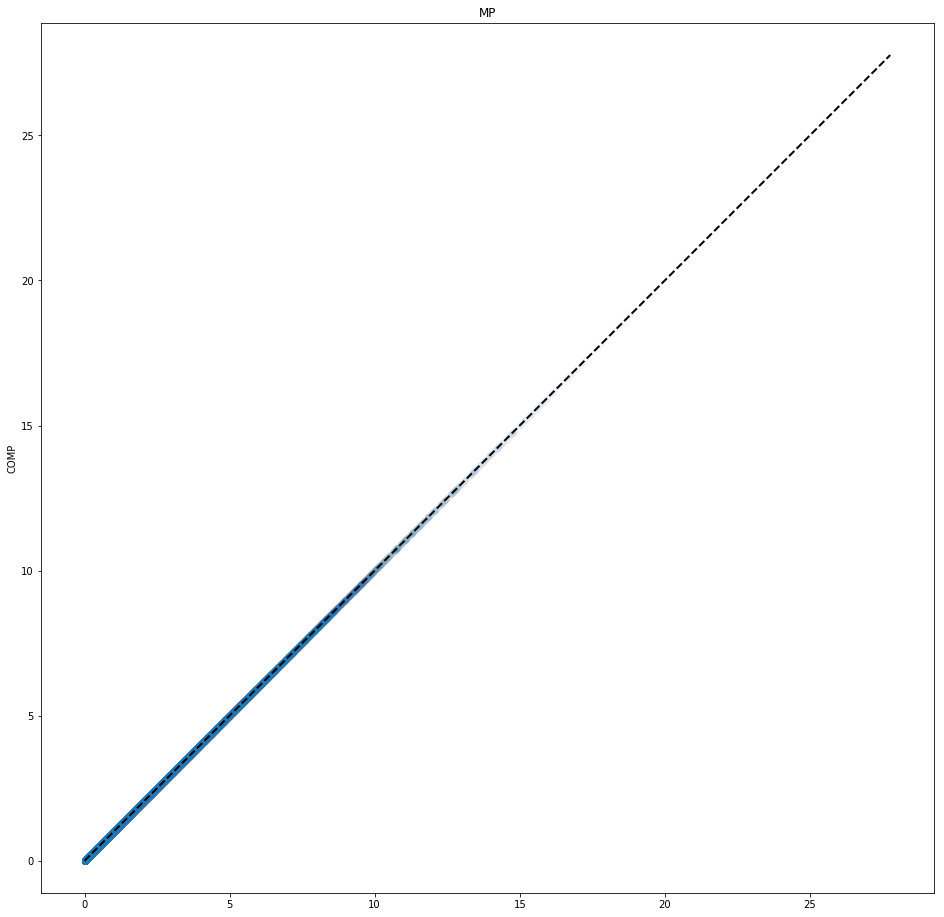

In [23]:
fig, ax = plot_scatter_MpVsComp(sparse_code_mp, sparse_code_comp)

## gradient descent 

Shape of modulation function (324, 512)
Learning step 0


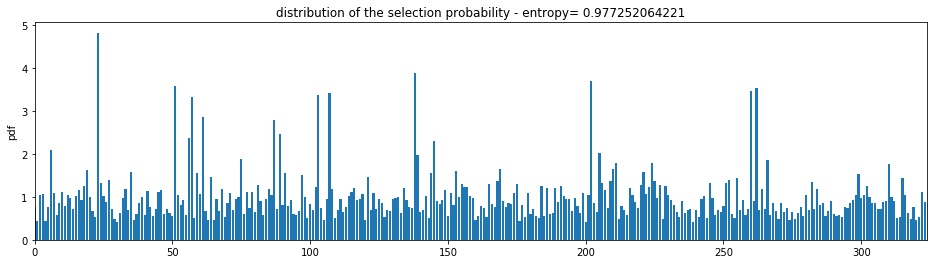

Learning step 100


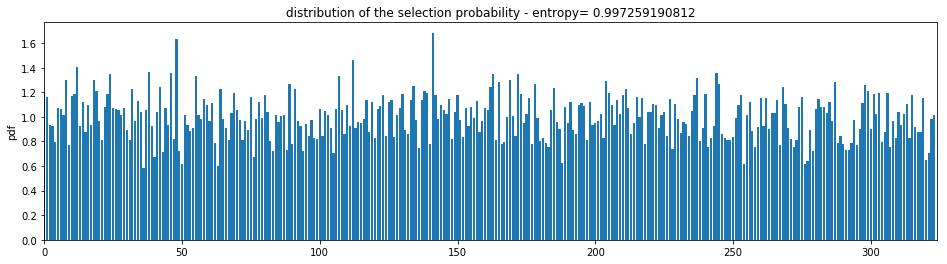

Learning step 200


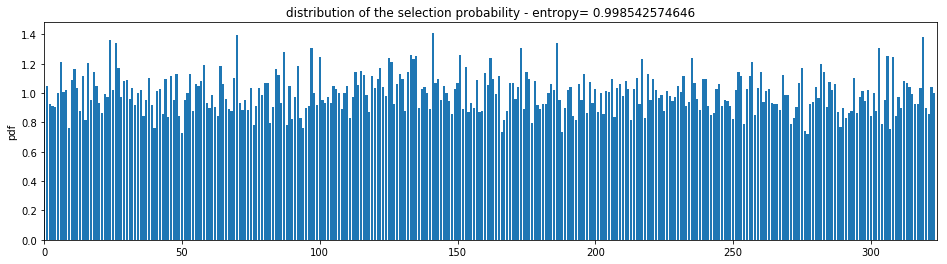

Learning step 300


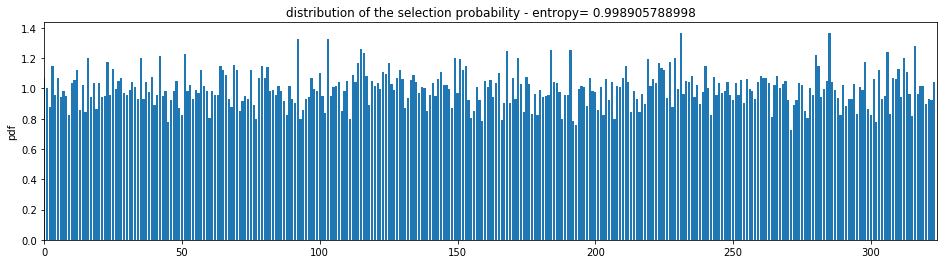

Learning step 400


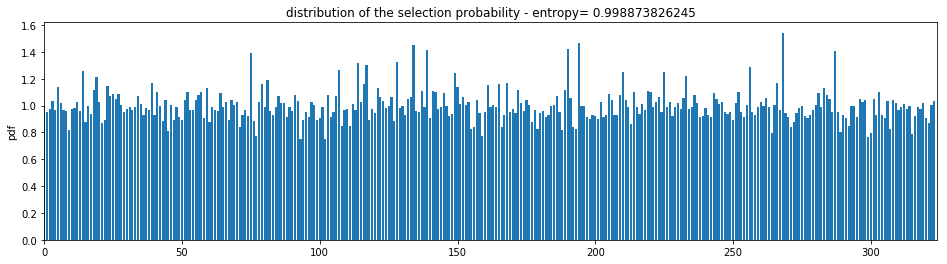

Learning step 500


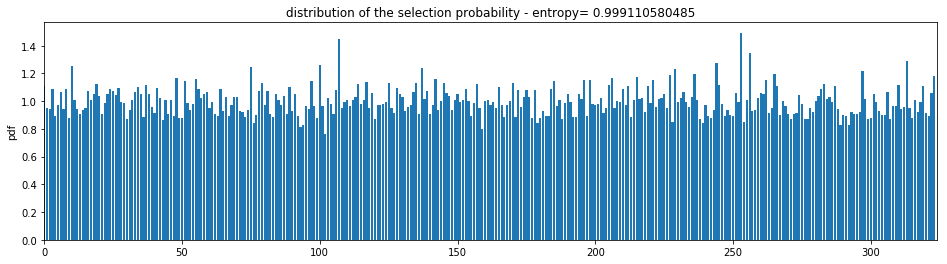

Learning step 600


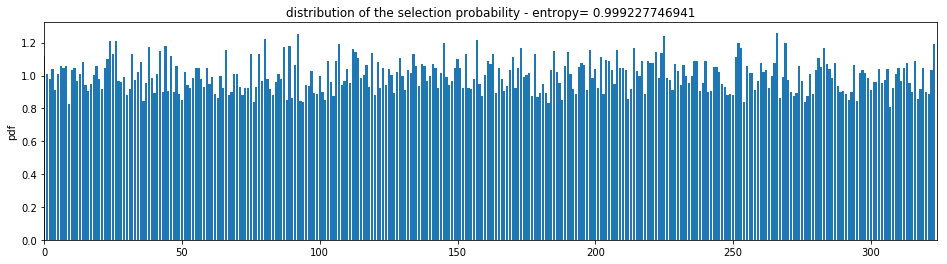

Learning step 700


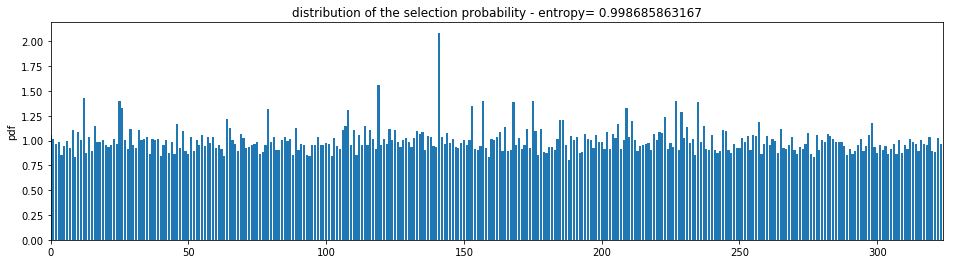

Learning step 800


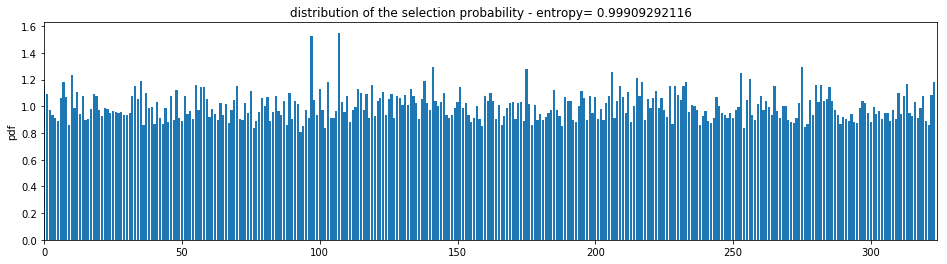

Learning step 900


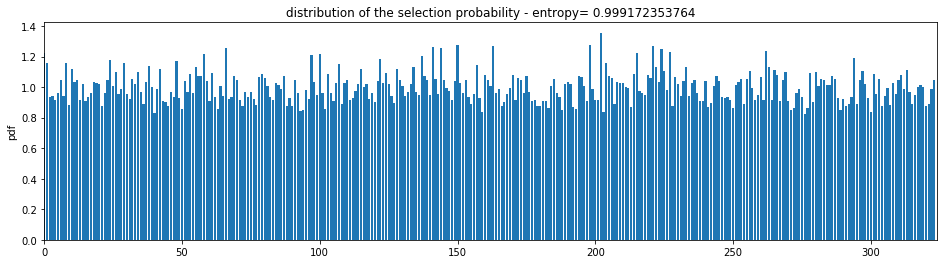

In [24]:
P_cum_new = np.linspace(0, 1, nb_quant, endpoint=True)[np.newaxis, :] * np.ones((nb_filter, 1))
print('Shape of modulation function', P_cum.shape)

eta_homeo = .005

for i in range(1000//DEBUG_DOWNSCALE):
    sparse_code_comp = comp(data_test, dico_partial_learning.dictionary, code_bins, P_cum_new, verbose=0)
    P_cum_ = get_P_cum(sparse_code_comp, nb_quant=nb_quant)
    P_cum_new = (1-eta_homeo) * P_cum_new + eta_homeo  * P_cum_
    if i % (100//DEBUG_DOWNSCALE) == 0:
        print('Learning step', i)
        fig, ax = plot_proba_histogram(sparse_code_comp)
        plt.show()

One observes that the distribution gets progressively more uniform which was our goal. However, this implementation makes the Matching Pursuit algorithm very slow such that we need to speed things up. This will be done in the [next post](https://laurentperrinet.github.io/sciblog/posts/2017-03-29-testing-comps-fastpcum.html).

Note the shape of the initial non-linear functions:

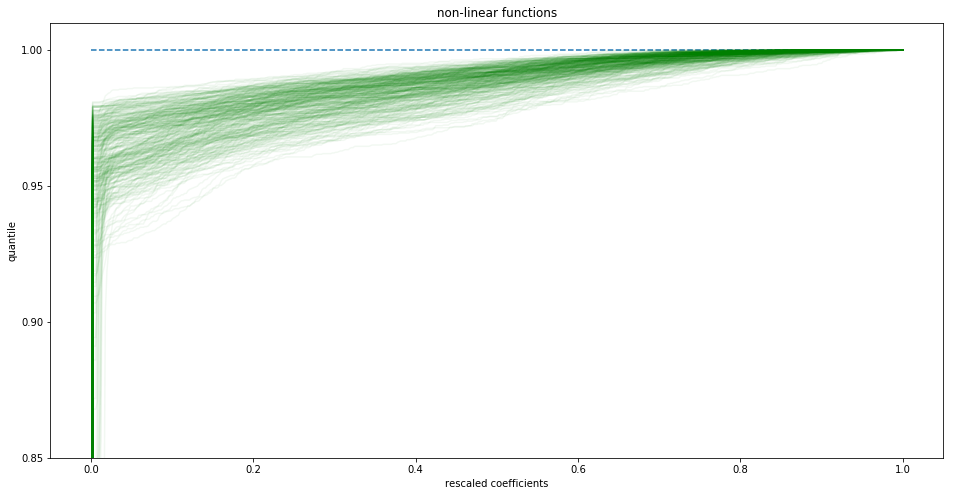

In [25]:
from shl_scripts.shl_tools import plot_P_cum
fig, ax = plot_P_cum(P_cum_mp, verbose=False);
ax.set_ylim(0.85, 1.01);

With that at convergence:

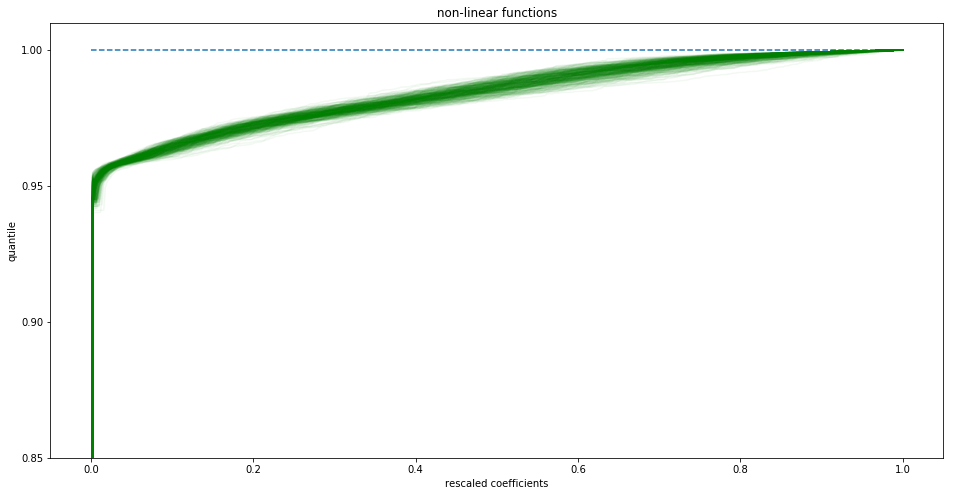

In [26]:
from shl_scripts.shl_tools import plot_P_cum
fig, ax = plot_P_cum(P_cum_new, verbose=False);
ax.set_ylim(0.85, 1.01);

Indeed, as the unsupervised learning is forced to be homeostatic, the filters that are learned ultimately converge to features of equal "saillance", such that the non-linear functions are approximately equal at convergence: In a equalitarian network at convergence, there is no need for these rules anymore (unless you want to learn again).

## Version used

In [27]:
%load_ext version_information
%version_information numpy, shl_scripts

Software versions
Python 3.6.3 64bit [GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.37)]
IPython 5.0.0
OS Darwin 17.2.0 x86_64 i386 64bit
numpy 1.13.3
shl_scripts 2017-02-09
Sun Dec 03 06:29:50 2017 CET